In [19]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings('ignore') 
import numpy as np
import matplotlib.pyplot as plt
import torch
from data import fetch_dataloaders
from maf import MAF
from attrdict import AttrDict
import importlib 

sys.path.append('/Users/david/workspace/mce/')
import src.woe_utils as utils
import src.woe as woe
x
# import woe_utils as utils
# import woe

In [10]:
#importlib.reload(utils)
from src.woe_utils import restore_model_from_file


In [66]:
results_dir = 'results/maf/'

#-----------

n_blocks = 5
n_hidden = 2
hidden_size = 1024
typ = 'fwd'

model_A_dir  = os.path.join(results_dir, 'blocks_{}/B{}_H{}_{}'.format(typ, n_blocks, n_hidden, hidden_size))
fwd_model, args = restore_model_from_file(os.path.join(model_A_dir, 'best_model_checkpoint.pt'))



#-----------

n_blocks = 5
n_hidden = 2
hidden_size = 128
typ = 'rnd'


#B5_H2_128_lr1e-5

#/Users/david/workspace/normalizing_flows/results/maf/blocks_rnd/B5_H1_2014_lr1e-5

model_A_dir  = os.path.join(results_dir, 'blocks_{}/B{}_H{}_{}_lr1e-5'.format(typ, n_blocks, n_hidden, hidden_size))
rnd_model, args = restore_model_from_file(os.path.join(model_A_dir, 'best_model_checkpoint.pt'))


#-----------

n_blocks = 5
n_hidden = 2
hidden_size = 128
typ = 'rnd'

#B5_H2_128_lr1e-5

#/Users/david/workspace/normalizing_flows/results/maf/blocks_rnd/B5_H1_2014_lr1e-5

model_A_dir  = os.path.join(results_dir, 'blocks_{}/B{}_H{}_{}_lr1e-5_v2'.format(typ, n_blocks, n_hidden, hidden_size))
rnd_model_2, args = restore_model_from_file(os.path.join(model_A_dir, 'best_model_checkpoint.pt'))




#------------

n_blocks = 5
n_hidden = 2
hidden_size = 1024
typ = 'bwd'


model_B_dir  = os.path.join(results_dir, 'blocks_{}/B{}_H{}_{}'.format(typ, n_blocks, n_hidden, hidden_size))
bwd_model, args = restore_model_from_file(os.path.join(model_B_dir, 'best_model_checkpoint.pt'))

# #-----------

# n_blocks = 5
# n_hidden = 1
# hidden_size = 128
# typ = 'rnd'

# model_B_dir  = os.path.join(results_dir, 'blocks_{}/B{}_H{}_{}'.format(typ, n_blocks, n_hidden, hidden_size))
# bwd_model, args = restore_model_from_file(os.path.join(model_B_dir, 'best_model_checkpoint.pt'))



Saved model doesnt have args
AttrDict({'dataset': 'MNIST', 'model': 'maf', 'flip_toy_var_order': False, 'input_size': 784, 'input_dims': (1, 28, 28), 'cond_label_size': 10, 'activation_fn': 'relu', 'conditional': True, 'no_batch_norm': False, 'batch_size': 100, 'lr': 0.0001, 'n_blocks': 5, 'n_hidden': 2, 'hidden_size': 1024, 'input_order': 'blocks', 'device': device(type='cpu')})
Loaded model from epoch 48 succesfully
Namespace(activation_fn='relu', batch_size=100, cond_label_size=10, conditional=True, data_dir='./data/', dataset='MNIST', device=device(type='cpu'), evaluate=False, flip_toy_var_order=False, generate=False, hidden_size=128, input_dims=(1, 28, 28), input_order='blocks-random', input_size=784, log_interval=1000, lr=1e-05, model='maf', n_blocks=5, n_components=1, n_epochs=100, n_hidden=2, no_batch_norm=False, no_cuda=False, output_dir='./results/maf/blocks_rnd/B5_H2_128_lr1e-5', restore_file='./results/maf/blocks_rnd/B5_H2_128_lr1e-5/model_checkpoint.pt', results_file='./re

In [82]:
# load data
if args.conditional: assert args.dataset in ['MNIST', 'CIFAR10'], 'Conditional inputs only available for labeled datasets MNIST and CIFAR10.'
train_dataloader, test_dataloader = fetch_dataloaders(args.dataset, args.batch_size, args.device, args.flip_toy_var_order)
# args.input_size = train_dataloader.dataset.input_size
# args.input_dims = train_dataloader.dataset.input_dims
# args.cond_label_size = train_dataloader.dataset.label_size if args.conditional else None

In [101]:
def ll_conditional(model,x, y, args, return_conditional = False):# x, y, args):
    logprior = torch.log(torch.tensor(1 / args.cond_label_size)).to(args.device)
    loglike = [[] for _ in range(args.cond_label_size)]

    for i in range(args.cond_label_size):
        # make one-hot labels
        labels = torch.zeros(args.batch_size, args.cond_label_size).to(args.device)
        labels[:,i] = 1

        x = x.view(x.shape[0], -1).to(args.device)
        #y = y.to(args.device)
        loglike[i] = model.log_prob(x, labels)
        #print(loglike[i])

        #loglike[i] = torch.cat(loglike[i], dim=0)   # cat along data dim under this label
    loglike = torch.stack(loglike, dim=1)           # cat all data along label dim
    
    if return_conditional:
        return loglike
    else:
        # log p(x) = log ∑_y p(x,y) = log ∑_y p(x|y)p(y)
        # assume uniform prior      = log p(y) ∑_y p(x|y) = log p(y) + log ∑_y p(x|y)
        logprobs = logprior + loglike.logsumexp(dim=1)
        # TODO -- measure accuracy as argmax of the loglike
        return logprobs

x,y = next(iter(train_dataloader)) 

print(x.min(), x.max())

# print(ll_conditional(fwd_model, x, y, args, return_conditional = False))

# logprobs = ll_conditional(fwd_model, x, y, args, return_conditional = True)

# # safety check - max logprob should match true class
# print(logprobs.max(1)[1] == y.max(1)[1])



tensor(-13.7651) tensor(12.3024)


tensor(-11.6970) tensor(6.3146)


tensor(1.3663e-06) tensor(0.9998)


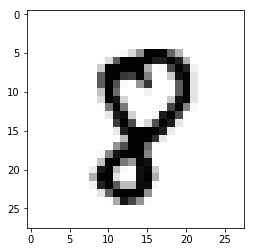

In [93]:
#import src.data as data
sys.path.append('./')
import data
importlib.reload(data)
from data import invlogit

#x.exp()
#print(invlogit(x[0])[:10])
#print(logistic(x[0])[:10])

def logistic(x):
    """
    Elementwise logistic sigmoid.
    :param x: numpy array
    :return: numpy array
    """
    return 1.0 / (1.0 + np.exp(-x))


B = invl(invlogit(x[0]))

def invl(x, lam = 1e-6):
    #FWD: lam + (1 - 2 * lam) * x
    #INV: 
    return (x - lam)/(1-2*lam)


print(B.min(), B.max())


plt.imshow(invl(invlogit(x[0]).reshape(28,28)), cmap = 'Greys')
plt.show()

In [96]:
B = x[0].reshape(28,28).clone()
B = invl(invlogit(B))
print(B.min(), B.max(), B.mean())

tensor(1.3663e-06) tensor(0.9998) tensor(0.1398)


In [11]:
#def model_ensemble_factory(m1, m2):


class MAFEnsemble():
    def __init__(self,models, mean_type = 'geometric'):
        self.mean_type = 'geometric'
        self.models = models
        self.base_dist = models[0].base_dist
    
    def log_prob(self, x, y = None):
        logprobs = [model.log_prob(x,y) for model in self.models]
        if self.mean_type == 'geometric':
            # Log Geom mean of probs is arith mean of logprobs
            return torch.mean(torch.stack(logprobs), dim = 0)
        if self.mean_type == 'arithmetic':
            # Will need to to logsumexp(torch.stack(logprobs), dim = 0) - log(n)
            raise NotImplemented()

#     def forward(self, x, y):
#         u, log_abs_det_jacobian = self.forward(x, y)
    def log_prob_partial(self, entries, x, y = None):
        logprobs = [model.log_prob_partial(entries,x,y) for model in self.models]
        if self.mean_type == 'geometric':
            # Log Geom mean of probs is arith mean of logprobs
            return torch.mean(torch.stack(logprobs), dim = 0)
        if self.mean_type == 'arithmetic':
            # Will need to to logsumexp(torch.stack(logprobs), dim = 0) - log(n)
            raise NotImplemented()
ens_model = MAFEnsemble(models=(fwd_model, bwd_model))

print(ll_conditional(ens_model, x, y, args, return_conditional = False))



tensor([-1158.6510, -1168.0026, -1150.4774, -1168.0531, -1151.6332, -1224.9725,
        -1152.6499, -1196.5760, -1167.9371, -1157.4290, -1186.5404, -1108.2720,
        -1147.6561, -1186.0267, -1237.3707, -1165.0786, -1178.0045, -1204.3739,
        -1186.3417, -1141.8168, -1092.7015, -1222.3492, -1200.5653, -1119.1134,
        -1116.6239, -1187.4530, -1098.3112, -1208.9034, -1273.0787, -1153.6426,
        -1174.9620, -1099.0743, -1388.8354, -1185.6096, -1187.6902, -1169.6154,
        -1221.4679, -1263.1837, -1203.8446, -1145.4777, -1142.8900, -1202.8923,
        -1194.9857, -1221.0983, -1219.4386, -1132.6571, -1119.2260, -1308.6980,
        -1267.0270, -1300.9484, -1177.8436, -1105.6868, -1273.3529, -1282.5992,
        -1248.6454, -1264.2156, -1221.3466, -1256.8285, -1231.6029, -1157.5638,
        -1189.6295, -1240.5914, -1158.9756, -1177.1639, -1085.6106, -1205.4843,
        -1214.8033, -1180.5688, -1195.2019, -1154.8491, -1178.5160, -1292.1771,
        -1179.3402, -1224.0990, -1213.82

In [52]:
print(x.min(), x.max())

tensor(-13.6642) tensor(12.7168)


torch.Size([100, 784]) torch.Size([100, 10])
tensor(59)


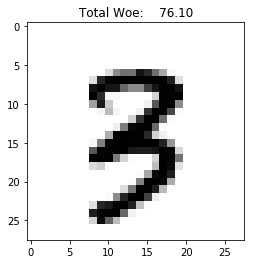

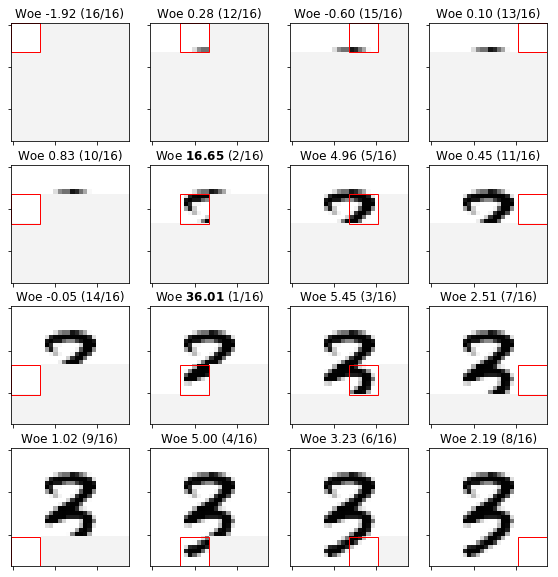

In [16]:
#%autoreload 2
#from data import logistic

import pdb 


import utils
import woe
importlib.reload(woe)
importlib.reload(utils)
from woe import get_woe, decomposition_woe



try:
    print(X.shape, Y.shape)
except:
    X,Y = next(iter(train_dataloader)) 

x = X[:,:]
y = Y[:,:]

h1 = [3]
h2 = [8]

total_woe, partial_woes = decomposition_woe(fwd_model, x, h1, h2,  args, plot=True,exid = None, rgba = False)
# print(partial_woes)
# print(partial_woes.shape)


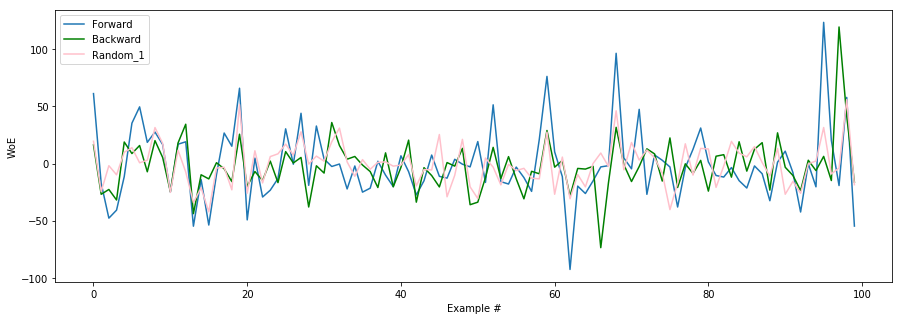

[95 68 59 19  0 98 52  6 71 27  5 29 79 25  8 17 58 96 50 12  7 11  9 18
 78 90 60 73 44 40 69 21 30 47 74 37 80 89 93 32 48 26 67 86 34 31 49 66
 75 55 83 77 70 41 91 87 16 38 81 45  4 61 82 56 46 24 14 84 43 65 53 51
  1 54 28 97 63 39 94 85 36 33 23 57 10 35 64 72 42 22 88 76  3 92  2 20
 15 99 13 62]
[68 95 59 98  0 27 19 56 17  6 25 83 11 52  8  4 12 48 79 90 96 49 57 93
 51 32 77 84  9 89 29 38 72 80 31 18 30 44 58 36 87  5 24 71 47 64 69 88
 50 70 37 55 67 86 21  2 82 73 16 45 78 60 54 53 41 85 20 14  7 40 91 94
 33 42 61 75 43 23 28 63 74 39 26 66 22 81  1 99  3 65 34 35 76 46 97 13
 10 92 15 62]
[97 98 31 12 68 59 89 19 75 41  8 84  4 87 11  0 32  6 52 48 72 86 25 38
  5 73 82 81 95 34 54 27  9 33 93 79 61 23 46 16 26 77 69 35 29 47 65 71
 60 90 40 43 63 17 64 94 85 57 21 36  7 30 78 58 14 91 44 83 51 53 55 15
 22 96 74 70 18 99 24 67 20 39 45 76 37  2 88 92 80 10  1 62 56  3 42 50
 49 28 13 66]
[98 19 68 95  8 32 27 59 45 48  0 83 31 70  9 77 25 86  5 79 89 80 72 11
 21  4 66

In [182]:

# Compare Total Woes

total_woe_fwd = get_woe(fwd_model, x, h1, h2,  args)
total_woe_bwd = get_woe(bwd_model, x, h1, h2,  args)
total_woe_rnd = get_woe(rnd_model, x, h1, h2,  args)
total_woe_rnd_2 = get_woe(rnd_model_2, x, h1, h2,  args)
plt.figure(figsize=(15,5))
plt.plot(total_woe_fwd.detach().numpy())
# plt.plot(total_woe_bwd.detach().numpy(), c = 'red')
plt.plot(total_woe_rnd.detach().numpy(), c = 'green')
plt.plot(total_woe_rnd_2.detach().numpy(), c = 'pink')
plt.legend(('Forward', 'Backward','Random_1', 'Random_2'))
plt.xlabel('Example #')
plt.ylabel('WoE')
plt.show()


# total_woe_fwd = get_woe(fwd_model, x, h1, h2,  args)
# total_woe_bwd = get_woe(rnd_model, x, h1, h2,  args)
# plt.plot(total_woe_fwd.detach().numpy())
# plt.plot(total_woe_bwd.detach().numpy(), c = 'red')
# plt.legend(('Forward', 'Random'))
# plt.xlabel('Example #')
# plt.ylabel('WoE')
# plt.show()



print(np.argsort(total_woe_fwd.detach().numpy())[::-1])
print(np.argsort(total_woe_bwd.detach().numpy())[::-1])
print(np.argsort(total_woe_rnd.detach().numpy())[::-1])
print(np.argsort(total_woe_rnd_2.detach().numpy())[::-1])

In [122]:

# total_woe, partial_woes = decomposition_woe(fwd_model, x, h1, h2,  args, exid = exidx,
#                                             plot=False, rgba = False, order = 'fwd', figsize = (10,10))
# print(total_woe[exidx], partial_woes[exidx, :])
# total_woe, partial_woes = decomposition_woe(fwd_model, x, h1, h2,  args, exid = exidx,
#                                             plot=False, rgba = False, order = 'bwd', figsize = (10,10))
# print(total_woe[exidx], partial_woes[exidx, :])




19


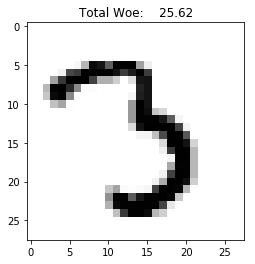

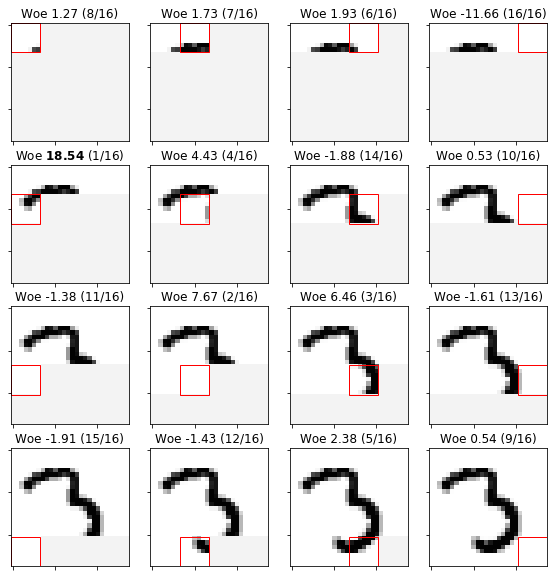

19


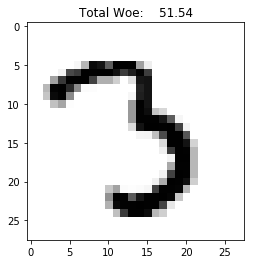

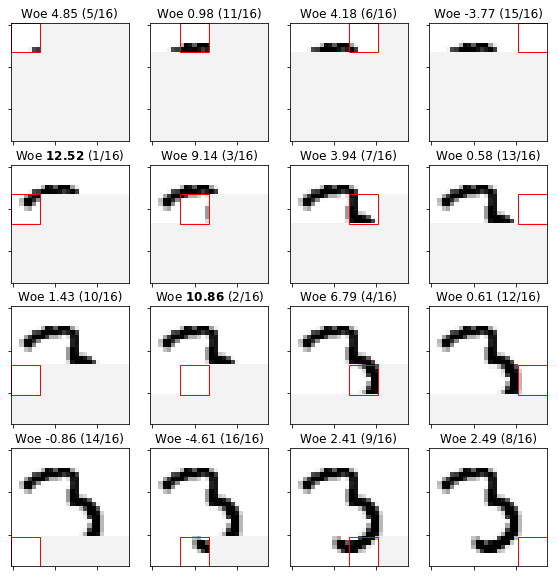

In [183]:
#%load_ext autoreload
%autoreload 2
importlib.reload(woe)
importlib.reload(utils)
from utils import get_block_order
from woe import decomposition_woe

exidx = 19

#total_woe, partial_woes = decomposition_woe(fwd_model, x, h1, h2,  args, exid = exidx, rgba = False, order = 'fwd', figsize = (10,10))

#total_woe, partial_woes = decomposition_woe(fwd_model, x, h1, h2,  args, exid = exidx, rgba = False, order = 'bwd', figsize = (10,10))

#total_woe, partial_woes = decomposition_woe(bwd_model, x, h1, h2,  args, exid = exidx, rgba = False, order = 'bwd', figsize = (10,10))

total_woe, partial_woes = decomposition_woe(rnd_model, x, h1, h2,  args, exid = exidx, rgba = False, order = 'fwd', figsize = (10,10))

total_woe, partial_woes = decomposition_woe(rnd_model_2, x, h1, h2,  args, exid = exidx, rgba = False, order = 'fwd', figsize = (10,10))



# print(partial_woes[exidx, :])
# total_woe, partial_woes = decomposition_woe(rnd_model, x, h1, h2,  args, exid = exidx, rgba = False, order = 'bwd', figsize = (10,10))
# print(partial_woes[exidx, :])

# total_woe, partial_woes = decomposition_woe(rnd_model, x, h1, h2,  args, exid = exidx, rgba = False, order = 'rnd', figsize = (10,10))
# print(partial_woes[exidx, :])






In [189]:
# def size_intersect1d(ar1, ar2, *kwargs):
#     print('Ar1', ar1)
#     print('Ar2', ar2)
#     print('Int', np.intersect1d(ar1, ar2,*kwargs))
#     return np.size(np.intersect1d(ar1, ar2,*kwargs))



u = np.array([[1,2,3,4,5], [1,2,3,4,5], [1,2,3,4,5]]) 
v = np.array([[3,4,1,2,5], [2,3,1,4,5], [1,2,3,4,5]]) 


# print(size_intersect1d(u[0], v[0]))
# print(size_intersect1d(u[1], v[1]))



ranking_agreement_score(u, v, k=3)

#ru = sp.stats.rankdata(u, method = 'ordinal')
#rv = sp.stats.rankdata(v, method = 'ordinal')




[0.3333333333333333, 0.6666666666666666, 1.0]

Mean agreement at top-1: 16.00%1: 11.00%. RAS@5: 37.20%.
Mean agreement at top-3: 30.50%
Mean agreement at top-5: 40.39%
Mean agreement at top-8: 55.99%


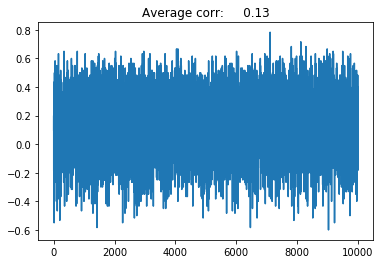

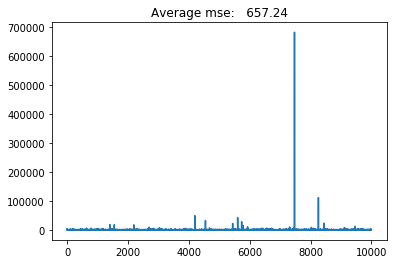

Considering only examples where total WOE difference < 5.0%
Mean agreement at top-1: 16.73%
Mean agreement at top-3: 30.24%
Mean agreement at top-5: 42.38%
Mean agreement at top-8: 56.92%


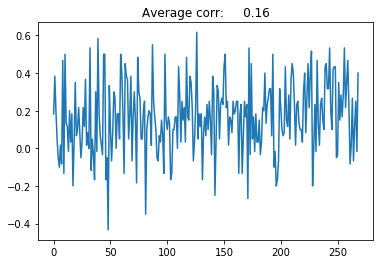

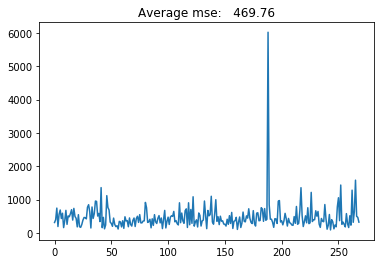

In [184]:

### Model Comparison


x = X[:,:]
y = Y[:,:]

h1 = [3]
h2 = [8]


import utils

importlib.reload(utils)

from woe import compare_model_woes

compare_model_woes(fwd_model, rnd_model_2, 'rnd', 'rnd', test_dataloader, h1, h2, args, filter_woes = 0.05)        

In [178]:
from utils import int2hot 
def eval_accuracy_density(model, dataloader):
    # Test model's classification accuracy by inversion with Bayes Rule
    correct = 0
    total   = 0
    for b, (x,y_true) in enumerate(dataloader):
        logprobs = torch.zeros(x.shape[0], args.cond_label_size)
        for i in range(args.cond_label_size):
            y = int2hot(torch.tensor([i]*x.shape[0]), args.cond_label_size)
            loglike = model.log_prob(x, y)
            logprobs[:,i] = loglike
        preds = logprobs.max(dim=1, keepdim=False)[1]
        correct +=  torch.eq(preds, y_true.max(dim=1)[1]).sum().item()
        total += x.shape[0]
        print('Batch: \t{}. Cumulative Accuracy:\t{:8.2f}%'.format(b,100*correct/total),  end="\r")
        #if b == 2: break
    acc = correct/total
    print('')
    return acc
    
acc = eval_accuracy_density(rnd_model, test_dataloader)
print('Total Accuracy:\t{:8.2f}%'.format(100*acc))
print('-----')       
    
    
acc = eval_accuracy_density(rnd_model_2, test_dataloader)
print('Total Accuracy:\t{:8.2f}%'.format(100*acc))
print('-----')       
        

# acc = eval_accuracy_density(fwd_model, test_dataloader)
# print('Total Accuracy:\t{:8.2f}%'.format(100*acc))
# print('-----')   

# acc = eval_accuracy_density(bwd_model, test_dataloader)
# print('Total Accuracy:\t{:8.2f}%'.format(100*acc))
# print('-----')   

Batch: 	99. Cumulative Accuracy:	   89.49%
Total Accuracy:	   89.49%
-----
Batch: 	99. Cumulative Accuracy:	   90.13%
Total Accuracy:	   90.13%
-----


# Best results for random:

85.29% : B5_H1_512_v2 batch_norm 1e-5 lr epoch 48
85.54% : B5_H1_512_v2 batch_norm 1e-5 lr epoch 9
83.73% : B5_H1_512_v2 batch_norm 1e-5 lr epoch 4

87.24% : B5_H1_256_v2 batch_norm 1e-5 lr epoch 6 (diverged after)


81.02% : B5_H1_1024  no_batch_norm 1e-5lr epoch 168 (nan after)

86.93% : B5_H2_128_lr1e-5  batch_norm 1e-5lr epoch 99

89.49% : B5_H2_128_lr1e-5  batch_norm 1e-5lr epoch 194

90.13% : B5_H2_128_lr1e-5_v2  batch_norm 1e-5lr epoch 198

86.98% : B5_H2_256_lr1e-5  batch_norm 1e-5lr epoch 81

89.48% : B5_H3_128_lr1e-5  batch_norm 1e-5lr epoch 290

85.94% : B5_H3_512_lr1e-5  batch_norm 5e-6lr epoch 68

92.44% : B5_H2_256 no_batch_norm epoch 985








## TRASH

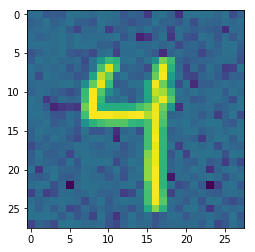

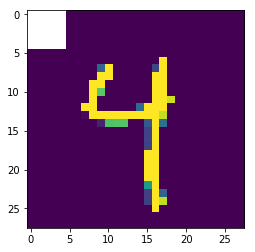

In [40]:
plt.imshow(x[0,:].reshape(28,28))
plt.show()


cmap = plt.get_cmap()

rgba_img = cmap(x[0,:].reshape(28,28))

rgba_img[:5,:5] = 0



plt.imshow(rgba_img, vmin = -0.7, vmax = 0)
plt.show()

In [39]:
x[0,:]

tensor([ -6.1037,  -5.8731,  -7.4024,  -7.1479,  -7.3124,  -5.6417,  -5.7195,
         -5.9061,  -6.3469,  -5.6385,  -5.7631,  -6.0222,  -7.4173,  -6.4864,
         -6.9720,  -9.1546,  -6.0396,  -5.6835,  -6.8250,  -9.7038,  -5.5900,
         -5.8377,  -5.5637,  -5.6167,  -6.4016,  -5.6800,  -8.0221,  -6.7339,
         -6.7837,  -6.3080,  -5.6762,  -6.8688,  -6.3090,  -5.6126,  -6.8289,
         -6.9199,  -7.3970,  -5.6060,  -6.0565,  -6.2060,  -6.8906,  -7.7829,
         -6.9546,  -6.8733,  -5.6982,  -6.5964,  -6.6514,  -7.2446,  -6.1061,
         -7.9960,  -6.1536,  -6.5070,  -6.4716,  -5.8950,  -6.4154,  -5.9000,
         -6.2841,  -6.0703,  -5.9380,  -6.2692,  -5.7615,  -7.0344,  -8.6222,
         -6.3219,  -6.2943,  -5.7365,  -9.0671,  -7.0882,  -6.8375,  -6.0217,
         -6.6036,  -5.8409,  -6.8460,  -6.2874,  -8.5761,  -5.9499,  -6.2864,
         -6.9862,  -6.6534,  -6.9192,  -7.2395,  -9.9842,  -6.1176,  -6.1209,
         -5.9773,  -6.7398,  -6.3016,  -5.9393,  -5.6728,  -6.32

In [14]:
print(total_woe[33])
print(partial_woes[33,:])
print(partial_woes[:,:-1].sum(1) - total_woe)

tensor(-19.0995, grad_fn=<SelectBackward>)
tensor([  2.6754,   2.3410,  -0.6062,   2.0803,   1.0592,   4.7482,  -4.6120,
         -0.7458,   0.9246,  -3.6208,   0.7824,   0.4825,  -9.2511, -15.5070,
          1.0030, -19.0995], grad_fn=<SelectBackward>)
tensor([ 0.4423,  0.2012,  0.2082,  1.1333, -0.1057,  1.4314,  0.4629,  0.7233,
         1.0264,  1.2408, -2.4060,  1.1903,  3.2202, -0.2163,  3.5773,  0.0898,
         5.0980, -0.3585,  0.7717,  2.6374,  1.4153,  3.6731,  0.7717, -3.4522,
        -0.8451, -0.7436, -0.5852,  2.3976,  1.6370,  3.0156, -1.5214, -2.6302,
         0.5378,  0.8533, -0.2403, -2.1813,  0.3383, -1.0455,  2.0751, -0.7616,
         2.8714, -2.9984,  0.2719,  0.7452,  3.1608,  2.0739, -1.5841, -3.4281,
        -1.1696,  3.8687,  1.1607,  1.2377, 11.2732, -2.8658,  1.0758,  0.6148,
         1.3629,  0.1080, -2.4435, -0.1881,  1.3811, -0.5662, -1.1495,  0.1724,
         0.2061,  0.6096, -0.3774,  1.8895, -0.0727,  3.3442,  1.2821,  2.6932,
         2.8623,  3.9034, 

In [ ]:



# X,Y = next(iter(train_dataloader)) 
# print(X.shape, Y.shape)

# x = X[:,:]
# y = Y[:,:]

h1 = [1,7,9]
h2 = 6

woe = get_woe(model, x, h1, h2,  args)


print(woe)
max_woe, max_woe_idx = woe.max(0)
min_woe, min_woe_idx = woe.min(0)
null_woe, null_woe_idx = torch.abs(woe).min(0)



plt.imshow(x[max_woe_idx,:].reshape(28,28))
plt.title('Max Woe: {:8.2f}'.format(max_woe))
plt.show()


plt.imshow(x[min_woe_idx,:].reshape(28,28))
plt.title('Min Woe: {:8.2f}'.format(min_woe))
plt.show()


plt.imshow(x[null_woe_idx,:].reshape(28,28))
plt.title('Null Woe: {:8.2f}'.format(null_woe))
plt.show()




In [57]:
print(max_woe, max_woe_idx, woe[33])

tensor(176.9983, grad_fn=<MaxBackward0>) tensor(33) tensor(176.9983, grad_fn=<SelectBackward>)


In [18]:
### Safety Check

print('LL1')
LL1 = generalized_conditional_ll(model, x, list(range(10)), args)
print('LL2')
LL2 = ll_conditional(model, x, y, args, return_conditional = False)


print(LL1 - LL2)




LL1
LL2
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<ThSubBackward>)


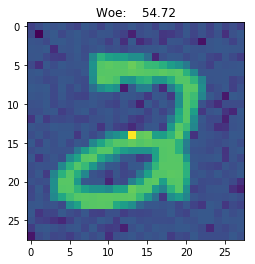

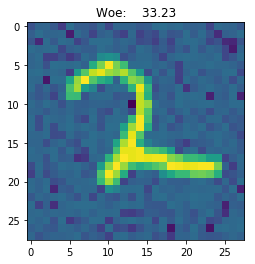

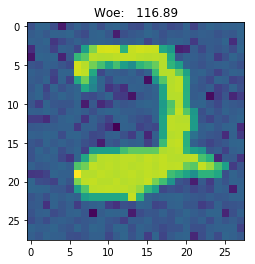

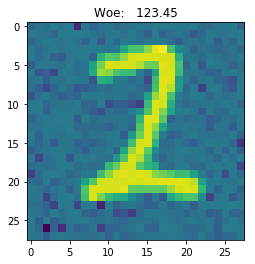

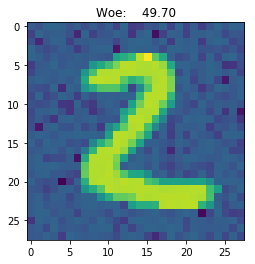

In [22]:
# Print some examples where true class is h1
true_y1 = (y.max(1)[1] == 2).nonzero().squeeze()
for idx in true_y1[:5]:
    plt.imshow(x[idx,:].reshape(28,28))
    plt.title('Woe: {:8.2f}'.format(woe[idx]))
    plt.show()

In [ ]:
def decomposition_woe():
    
    

In [ ]:
true_y2 = (y.max(1)[1] == h2).nonzero().squeeze()
for idx in true_y2[:5]:
    plt.imshow(x[idx,:].reshape(28,28))
    plt.title('Woe: {:8.2f}'.format(woe[idx]))
    plt.show()

In [ ]:
max_woe, max_woe_idx = woe.max(0)
min_woe, min_woe_idx = woe.min(0)
null_woe, null_woe_idx = torch.abs(woe).min(0)



plt.imshow(x[max_woe_idx,:].reshape(28,28))
plt.title('Max Woe: {:8.2f}'.format(max_woe))
plt.show()


plt.imshow(x[min_woe_idx,:].reshape(28,28))
plt.title('Min Woe: {:8.2f}'.format(min_woe))
plt.show()


plt.imshow(x[null_woe_idx,:].reshape(28,28))
plt.title('Min Woe: {:8.2f}'.format(null_woe))
plt.show()






In [ ]:
y1 = int2hot(1, args.cond_label_size)
print(y1)
ll = model.log_prob(x, y1)
print(ll)

y1[0,6] = 1
print(y1)
ll = model.log_prob(x, y1)


print(ll)

In [139]:
# import json

# results_file = os.path.join(model_dir, 'results.txt')

# with open(results_file, 'r') as f:
#     rstr =  [next(f).replace("\'", "\"") for x in range(3)]
# #[l for i,l in enumerate(f.readline()) if i< 10]
# #results = json.load(open(results_file, 'r'))
# rstr = ''.join(rstr)
# print(rstr)

# results = json.loads(rstr)


In [ ]:

    #torch.nn.functional.one_hot(3) Pytorch 1.0
    

print(int2hot(torch.tensor([3,6])))

print(int2hot(3, 10))



In [ ]:
x.dim()

In [106]:
# ### LOAD REVRESE MODEL TOO

# # model_type = 'new'

# # args.input_order = 'blocks-reverse'

# # if model_type == 'small': 
# #     results_dir = 'results_blocks_reverse'
# #     args.n_hidden = 3
# #     args.n_blocks = 5    
# # elif model_type == 'new':
# #     results_dir = 'results_blocks_reverse_new'
# #     args.n_hidden = 2
# #     args.n_blocks = 5    
# # else:
# #     results_dir = 'results_blocks_reverse_large'
# #     args.n_hidden = 5
# #     args.n_blocks = 10

# # results_dir = 'results/maf/'

# n_blocks = 5
# n_hidden = 3
# hidden_size = 1024
# typ = 'bwd'

# model_dir  = os.path.join(results_dir, 'blocks_{}/B{}_H{}_{}'.format(typ, n_blocks, n_hidden, hidden_size))
# model_file = os.path.join(model_dir, 'best_model_checkpoint.pt')


# try:
#     state = torch.load(model_file, map_location='cpu')
#     args = state['args']
# except:
#     args.n_blocks = n_blocks
#     args.n_hidden = n_hidden
#     args.hidden_size = hidden_size
#     args.restore_file = model_file


# args.device = torch.device('cuda:0' if torch.cuda.is_available() and not args.no_cuda else 'cpu')
# args.restore_file = model_file


# reverse_model = make_model(args)

# state = torch.load(args.restore_file, map_location=args.device)
# reverse_model.load_state_dict(state['model_state'])
# #args.start_epoch = state['epoch'] + 1
# #args.output_dir = os.path.dirname(args.restore_file)
# reverse_model.eval()




MAF(
  (net): FlowSequential(
    (0): MADE(
      (net_input): MaskedLinear(in_features=784, out_features=1024, bias=True, cond_features=10)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=1024, out_features=1024, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=1024, out_features=1024, bias=True)
        (4): ReLU()
        (5): MaskedLinear(in_features=1024, out_features=1024, bias=True)
        (6): ReLU()
        (7): MaskedLinear(in_features=1024, out_features=1568, bias=True)
      )
    )
    (1): BatchNorm()
    (2): MADE(
      (net_input): MaskedLinear(in_features=784, out_features=1024, bias=True, cond_features=10)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=1024, out_features=1024, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=1024, out_features=1024, bias=True)
        (4): ReLU()
        (5): MaskedLinear(in_features=1024, out_features=1024, bias=True)
   

In [ ]:
x.view(-1, 1).shape

In [ ]:
u, log_abs_det_jacobian = model.forward(x, y)


In [ ]:
print(x.shape, y.shape, u.shape, log_abs_det_jacobian.shape)

In [ ]:
print(model.base_dist.log_prob(u).shape)

In [39]:
#### blcok sampling

import numpy as np

n = 8
k = 2


IDX = np.zeros((n,n), dtype = int)
print(IDX)

[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


In [40]:
for i in range(n):
    for j in range(n):
        IDX[i,j] = i*n + j
        
print(IDX)




[[ 0  1  2  3  4  5  6  7]
 [ 8  9 10 11 12 13 14 15]
 [16 17 18 19 20 21 22 23]
 [24 25 26 27 28 29 30 31]
 [32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47]
 [48 49 50 51 52 53 54 55]
 [56 57 58 59 60 61 62 63]]


In [42]:
for i in range(n) :
    for j in range(n):
        I  = i // k
        J  = j // k
        ip = i % k # internal indexing within this block
        jp = j % k
        IDX[i,j] =  ((n/k)*I + J)*(k**2) + (ip*k + jp)
        
print(IDX)
        


[[ 0  1  4  5  8  9 12 13]
 [ 2  3  6  7 10 11 14 15]
 [16 17 20 21 24 25 28 29]
 [18 19 22 23 26 27 30 31]
 [32 33 36 37 40 41 44 45]
 [34 35 38 39 42 43 46 47]
 [48 49 52 53 56 57 60 61]
 [50 51 54 55 58 59 62 63]]


In [46]:

idx2block = dict(zip(range(n**2), IDX.flatten()))
print(idx2block)

block2idx = sorted(dict(zip(IDX.flatten(), range(n**2))))

print(block2idx)



{0: 0, 1: 1, 2: 4, 3: 5, 4: 8, 5: 9, 6: 12, 7: 13, 8: 2, 9: 3, 10: 6, 11: 7, 12: 10, 13: 11, 14: 14, 15: 15, 16: 16, 17: 17, 18: 20, 19: 21, 20: 24, 21: 25, 22: 28, 23: 29, 24: 18, 25: 19, 26: 22, 27: 23, 28: 26, 29: 27, 30: 30, 31: 31, 32: 32, 33: 33, 34: 36, 35: 37, 36: 40, 37: 41, 38: 44, 39: 45, 40: 34, 41: 35, 42: 38, 43: 39, 44: 42, 45: 43, 46: 46, 47: 47, 48: 48, 49: 49, 50: 52, 51: 53, 52: 56, 53: 57, 54: 60, 55: 61, 56: 50, 57: 51, 58: 54, 59: 55, 60: 58, 61: 59, 62: 62, 63: 63}
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]


In [67]:
torch.tensor(order)

tensor([  0,   1,   2,   3,  28,  29,  30,  31,  56,  57,  58,  59,  84,  85,
         86,  87,   4,   5,   6,   7,  32,  33,  34,  35,  60,  61,  62,  63,
         88,  89,  90,  91,   8,   9,  10,  11,  36,  37,  38,  39,  64,  65,
         66,  67,  92,  93,  94,  95,  12,  13,  14,  15,  40,  41,  42,  43,
         68,  69,  70,  71,  96,  97,  98,  99,  16,  17,  18,  19,  44,  45,
         46,  47,  72,  73,  74,  75, 100, 101, 102, 103,  20,  21,  22,  23,
         48,  49,  50,  51,  76,  77,  78,  79, 104, 105, 106, 107,  24,  25,
         26,  27,  52,  53,  54,  55,  80,  81,  82,  83, 108, 109, 110, 111,
        112, 113, 114, 115, 140, 141, 142, 143, 168, 169, 170, 171, 196, 197,
        198, 199, 116, 117, 118, 119, 144, 145, 146, 147, 172, 173, 174, 175,
        200, 201, 202, 203, 120, 121, 122, 123, 148, 149, 150, 151, 176, 177,
        178, 179, 204, 205, 206, 207, 124, 125, 126, 127, 152, 153, 154, 155,
        180, 181, 182, 183, 208, 209, 210, 211, 128, 129, 130, 1

In [76]:
input_size = 68
hidden_size = 20
n_hidden = 2
input_degrees = None
degrees = []
degrees += [torch.arange(input_size)] if input_degrees is None else [input_degrees]
for _ in range(n_hidden + 1):
    degrees += [torch.arange(hidden_size) % (input_size - 1)]
degrees += [torch.arange(input_size) % input_size - 1] if input_degrees is None else [input_degrees % input_size - 1]
print(degrees)

[tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]), tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19]), tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19]), tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19]), tensor([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
        53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66])]


In [77]:
degrees[-1]

tensor([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
        53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66])

In [73]:
torch.arange(hidden_size) % (input_size - 1)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [92]:
degrees = []
degrees += [torch.randperm(input_size)] if input_degrees is None else [input_degrees]
for _ in range(n_hidden + 1):
    min_prev_degree = int(min(degrees[-1].min().item(), input_size - 1))
    print(min_prev_degree, input_size, (hidden_size,))
    degrees += [torch.randint(min_prev_degree, input_size, (hidden_size,))]
    print(degrees[-1])
min_prev_degree = int(min(degrees[-1].min().item(), input_size - 1))
degrees += [torch.randint(min_prev_degree, input_size, (input_size,)) - 1] if input_degrees is None else [input_degrees - 1]

0 68 (20,)
tensor([23., 10.,  0.,  6., 40., 40.,  3., 57., 24.,  2., 47., 48., 60.,  7.,
        10., 51.,  4., 52.,  2., 23.])
0 68 (20,)
tensor([11., 36., 67.,  7., 59., 67., 31., 54., 49., 42., 26., 42., 61.,  0.,
        39.,  9., 66., 66.,  3., 16.])
0 68 (20,)
tensor([40.,  7., 10.,  1.,  2., 58., 12., 53., 27., 38., 59.,  1., 36.,  6.,
        42., 48., 31., 48., 59., 37.])


In [89]:
int(min(degrees[-1].min().item(), input_size - 1))

5

In [88]:
input_size - 1

67

In [94]:
torch.randint(min_prev_degree, input_size, (hidden_size,))

tensor([24., 15., 10., 56., 27., 31., 23., 35., 24., 19., 48.,  1., 49., 55.,
        63., 52., 64.,  4., 47., 20.])